In [61]:
import cv2
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import shutil
from scipy.spatial.distance import cosine
import numpy as np
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt


In [4]:
# Load the CSV file
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Instantiate the same model architecture
base_model = tf.keras.applications.InceptionV3(weights=None, include_top=False, input_shape=(150, 150, 3))
for layer in base_model.layers[:-1]:  # Unfreeze last 10 layers
    layer.trainable = True

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = layers.Dense(1024, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.3)(x)
predictions = layers.Dense(105, activation='softmax')(x)
model = models.Model(inputs=base_model.input, outputs=predictions)

# Load the saved weights
model.load_weights('/content/drive/MyDrive/Deep learning lab6/my_model_weights.weights.h5')

# Compile the model
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])


In [6]:
# Define paths
train_dir = "/content/drive/MyDrive/Deep learning lab6/train"
val_dir = "/content/drive/MyDrive/Deep learning lab6/val"
test_dir = "/content/drive/MyDrive/Deep learning lab6/test"

In [7]:
batch_num=64
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,target_size=(150, 150),batch_size=batch_num,class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(val_dir,target_size=(150, 150),batch_size=batch_num,class_mode='categorical')

test_generator = test_datagen.flow_from_directory(test_dir,target_size=(150, 150),batch_size=batch_num,class_mode='categorical')

Found 12225 images belonging to 105 classes.
Found 2632 images belonging to 105 classes.
Found 2675 images belonging to 105 classes.


In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


# Embeddings

In [6]:
average_embeddings = {}
count=0
for subdir in os.listdir(train_dir):
    count=count+1
    subdir_path = os.path.join(train_dir, subdir)
    if os.path.isdir(subdir_path):
        embeddings_list = []  # List to accumulate embeddings for the current subdir
        file_count=0
        for file in os.listdir(subdir_path):
            file_count = file_count+1
            file_path = os.path.join(subdir_path, file)
            if file.endswith('.jpg') or file.endswith('.jpeg') or file.endswith('.png'):
                face = cv2.imread(file_path)
                face = cv2.resize(face, (150, 150))  # Resize face to match input size
                face = np.expand_dims(face, axis=0)  # Add batch dimension
                face = face / 255.0  # Normalize
                embeddings = model.predict(face)
                embeddings_list.append(embeddings)  # Append embeddings for current image
            if file_count == 20:
                break

        # Compute average embeddings for the current subdir
        print(f"{count}. {subdir}")
        if embeddings_list:
            average_embeddings[subdir] = np.mean(embeddings_list, axis=0)
        else:
            average_embeddings[subdir] = None  # Handle empty directory case


1/1 [==============================] - 0s 30ms/step
1. pins_Wentworth Miller
1/1 [==============================] - 0s 26ms/step
2. pins_Ursula Corbero
1/1 [==============================] - 0s 34ms/step
3. pins_Tuppence Middleton
1/1 [==============================] - 0s 25ms/step
4. pins_tom ellis
1/1 [==============================] - 0s 25ms/step
5. pins_Tom Hiddleston
1/1 [==============================] - 0s 25ms/step
6. pins_Tom Hardy
1/1 [==============================] - 0s 24ms/step
7. pins_Zac Efron
1/1 [==============================] - 0s 115ms/step
8. pins_Zoe Saldana
1/1 [==============================] - 0s 39ms/step
9. pins_Zendaya
1/1 [==============================] - 0s 25ms/step
10. pins_Tom Holland
1/1 [==============================] - 0s 26ms/step
11. pins_Tom Cruise
1/1 [==============================] - 0s 47ms/step
12. pins_scarlett johansson
1/1 [==============================] - 0s 27ms/step
13. pins_Selena Gomez
1/1 [==============================] - 0s 24

In [8]:
np.save("/content/drive/MyDrive/Deep learning lab6/average_embeddings20.npy", average_embeddings)

In [7]:
import pandas as pd

average_embeddings2={}
for label, emb in average_embeddings.items():
       average_embeddings2[label] = emb.flatten().tolist()  # Flatten and convert to list
df = pd.DataFrame(average_embeddings2)
df.to_csv('/content/drive/MyDrive/Deep learning lab6/average_embeddings20.csv', index=False)

# Detect & Crop Faces

In [8]:
# Get the file paths
pb_files = '/content/drive/MyDrive/Deep learning lab6/opencv_face_detector_uint8.pb'
pbtxt_files = '/content/drive/MyDrive/Deep learning lab6/opencv_face_detector.pbtxt'
h5_files = '/content/drive/MyDrive/Deep learning lab6/inception_v3_weights_tf_dim_ordering_tf_kernels.h5'



In [9]:
# Load the OpenCV face detector model
net = cv2.dnn.readNetFromTensorflow(pb_files, pbtxt_files)


In [10]:
def detect_and_crop_faces(image_path):
    global net
    frame = cv2.imread(image_path)
    # Perform face detection
    blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300), [104., 177., 123.], False, False)
    net.setInput(blob)
    detections = net.forward()

    # Initialize variables to store the coordinates of the face if found
    face_coords = None

    # Process the detections
    for i in range(0, detections.shape[2]):
        # Get the confidence (probability) of the current detection:
        confidence = detections[0, 0, i, 2]

        # Only consider detections if confidence is greater than a fixed minimum confidence:
        if confidence > 0.7:
            # Get the coordinates of the current detection:
            box = detections[0, 0, i, 3:7] * np.array([frame.shape[1], frame.shape[0], frame.shape[1], frame.shape[0]])
            (startX, startY, endX, endY) = box.astype("int")

            # Update face_coords with the coordinates of the current detection
            face_coords = (startX, startY, endX, endY)

            # Break out of the loop as soon as one face is found
            break

    # If face_coords is None, it means no face was found, so return None
    if face_coords is None:
        return None

    # Otherwise, crop the face region using the coordinates and return it
    (startX, startY, endX, endY) = face_coords
    face = frame[startY:endY, startX:endX]
    plt.imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
    plt.title('Detected Face')
    plt.axis('off')
    plt.show()

    return face


# Cosine similarity

In [59]:
def cosine_similarity(vec1, vec2):
    vec1 = np.array(vec1, dtype=np.float32)  # Convert to float32 array
    vec2 = np.array(vec2, dtype=np.float32)  # Convert to float32 array
    if vec1.size == 0 or vec2.size == 0:
        print("Error: Empty vector(s) detected.")
        return None

    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    similarity = dot_product / (norm_vec1 * norm_vec2)
    return similarity


def recognize_face(image_path,average_embeddings):

    # Preprocess image to extract face
    face = detect_and_crop_faces(image_path)
    if face is None:
        print("No face detected in the image.")
        return

    # Generate embedding for the extracted face
    face = cv2.resize(face, (150, 150))  # Resize face to match input size
    face = np.expand_dims(face, axis=0)  # Add batch dimension
    face = face / 255.0  # Normalize
    face_embedding = model.predict(face)

    best_similarity = -1
    similarities={}
    for label, emb in average_embeddings.items():
        similarity = cosine_similarity(face_embedding.flatten(), emb.flatten())
        if similarity > best_similarity:
            best_similarity = similarity
            best_match_label = label

    # If the best similarity exceeds a certain threshold, consider it a match
    if best_similarity > 0.95:  # Adjust this threshold as needed
        print(f"Recognized as: {best_match_label} (Similarity: {best_similarity:.2f})")

    else:
        print("Unknown face")
        print(f"Similarity: {best_similarity:.2f}")

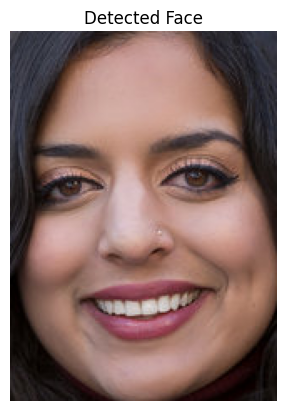

1/1 [==============================] - 0s 27ms/step
Unknown face
Similarity: 0.73


In [82]:
recognize_face("/content/drive/MyDrive/Deep learning lab6/Final/faces/faceF8.jpg",average_embeddings)

# Cosine similarity for live script

In [27]:
def detect_and_crop_faces2(frame):
    global net
    # frame = cv2.imread(image_path)
    # Perform face detection
    blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300), [104., 177., 123.], False, False)
    net.setInput(blob)
    detections = net.forward()

    # Initialize variables to store the coordinates of the face if found
    face_coords = None

    # Process the detections
    for i in range(0, detections.shape[2]):
        # Get the confidence (probability) of the current detection:
        confidence = detections[0, 0, i, 2]

        # Only consider detections if confidence is greater than a fixed minimum confidence:
        if confidence > 0.7:
            # Get the coordinates of the current detection:
            box = detections[0, 0, i, 3:7] * np.array([frame.shape[1], frame.shape[0], frame.shape[1], frame.shape[0]])
            (startX, startY, endX, endY) = box.astype("int")

            # Update face_coords with the coordinates of the current detection
            face_coords = (startX, startY, endX, endY)

            # Break out of the loop as soon as one face is found
            break

    # If face_coords is None, it means no face was found, so return None
    if face_coords is None:
        return None

    # Otherwise, crop the face region using the coordinates and return it
    (startX, startY, endX, endY) = face_coords
    face = frame[startY:endY, startX:endX]

    return face


In [23]:
from scipy.spatial.distance import cosine

# def cosine_similarity(vec1, vec2):
#     dot_product = np.dot(vec1, vec2)
#     norm_vec1 = np.linalg.norm(vec1)
#     norm_vec2 = np.linalg.norm(vec2)
#     similarity = dot_product / (norm_vec1 * norm_vec2)
#     return similarity

import numpy as np

def cosine_similarity(vec1, vec2):
    vec1 = np.array(vec1, dtype=np.float32)  # Convert to float32 array
    vec2 = np.array(vec2, dtype=np.float32)  # Convert to float32 array
    if vec1.size == 0 or vec2.size == 0:
        print("Error: Empty vector(s) detected.")
        return None

    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    similarity = dot_product / (norm_vec1 * norm_vec2)
    return similarity


def recognize_face2(image,average_embeddings):

    # Preprocess image to extract face
    face = detect_and_crop_faces2(image)
    if face is None:
        print("No face detected in the image.")
        return

    # Generate embedding for the extracted face
    face = cv2.resize(face, (150, 150))  # Resize face to match input size
    face = np.expand_dims(face, axis=0)  # Add batch dimension
    face = face / 255.0  # Normalize
    face_embedding = model.predict(face)

    best_similarity = -1
    similarities={}
    for label, emb in average_embeddings.items():
#         similarity = 1 - cosine(face_embedding.flatten(), emb.flatten())
#         print(f"{label} (Similarity: {similarity:.2f})")
        similarity = cosine_similarity(face_embedding.flatten(), emb.flatten())
        if similarity > best_similarity:
            best_similarity = similarity
            best_match_label = label

    # If the best similarity exceeds a certain threshold, consider it a match
    if best_similarity > 0.95:  # Adjust this threshold as needed
        print(f"Recognized as: {best_match_label} (Similarity: {best_similarity:.2f})")

    else:
        print("Unknown face")
        print(f"Similarity: {best_similarity:.2f}")
    return(best_match_label)

# Embeddings reading

In [ ]:
# Load the .npy file
data = np.load('/content/drive/MyDrive/Deep learning lab6/average_embeddings20.npy', allow_pickle=True)

# Access the dictionary
average_embeddings = data.item()

# Now you can work with your_dictionary
print(average_embeddings)

# Live stream

In [13]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [14]:
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [15]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [16]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0

# Inside your main loop
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # Convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # Perform face detection and recognition
    faces = face_cascade.detectMultiScale(img)
    for (x, y, w, h) in faces:
        # Crop detected face
        face = img[y:y+h, x:x+w]

        # Recognize face
        recognized_label = recognize_face2(face, average_embeddings)

        # Draw bounding box and label on the image
        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
        cv2.putText(img, str(recognized_label), (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    # Convert overlay of bbox into bytes
    bbox_array = cv2.cvtColor(img, cv2.COLOR_BGR2RGBA)
    bbox_bytes = bbox_to_bytes(bbox_array)
    # Update bbox so the next frame gets the new overlay
    bbox = bbox_bytes